# Join and Pre-Process the New York City Datasets

Code responsible to Join and Pre-Process three New York City datasets:

- Census: Census data of New York, with important info about: Race, Income, Poverty, Child Poverty and other sensible infos
- https://www.kaggle.com/muonneutrino/new-york-city-census-data

In [4]:
import pandas as pd

In [5]:
df_census = pd.read_table("Input/nyc_census_tracts.csv", sep = ',')
df_blocks = pd.read_table("Input/census_block_loc.csv", sep = ',')

In [6]:
dict_county = {'BRONX': 'BRONX', 'BROOKLYN': 'KINGS', 'MANHATTAN': 'NEW YORK',
               'QUEENS': 'QUEENS', 'STATEN ISLAND': 'RICHMOND'}

### Census: Removing NoN Interesting Columns

In [7]:
df_census['County'] = list(map(lambda x: x.upper(), df_census['County']))
df_census['Borough'] = list(map(lambda x: x.upper(), df_census['Borough']))
df_census.sort_values(by = ['CensusTract'], axis = 0,
                           inplace = True, na_position = 'last')
df_census.head(5)

,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,BRONX,BRONX,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,BRONX,BRONX,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,BRONX,BRONX,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,BRONX,BRONX,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,BRONX,BRONX,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


### Blocks: Pre-Processing

In [8]:
# The block code takes the form XXYYYZZZZZZAAAA where X=State, Y=County, Z=Tract, A=Block

df_blocks =  df_blocks.loc[df_blocks['State'] == 'NY']
df_blocks.sort_values(by = ['BlockCode'], axis = 0,
                      inplace = True, na_position = 'last')

df_blocks.drop(columns = ['State', 'County'], axis = 1, inplace = True)
df_blocks['BlockCode'] = list(map(lambda x: int(''.join(list(str(x))[:-4])), list(df_blocks['BlockCode'])))
df_blocks.head(5)

,Latitude,Longitude,BlockCode
26325,40.794322,-73.871608,36005000100
26318,40.794322,-73.893769,36005000100
26720,40.798844,-73.887437,36005000100
26523,40.796583,-73.877940,36005000100
26522,40.796583,-73.881106,36005000100


#### Mean Latitude e Longitude per Block

In [9]:
df_blocks = df_blocks.groupby('BlockCode', as_index=False).agg({'Latitude':'mean',
                                                               'Longitude':'mean'})

df_blocks.head(5)

,BlockCode,Latitude,Longitude
0,36005000100,40.792756,-73.883541
1,36005000200,40.805866,-73.860278
2,36005000400,40.807594,-73.851237
3,36005001600,40.819196,-73.858040
4,36005001900,40.801216,-73.909212


### Joining Datasets

In [10]:
df_census.rename(columns = {"CensusTract": "BlockCode"}, inplace = True)
df = pd.merge(df_blocks, df_census, on=['BlockCode'])
df.dropna(axis = 0, how = 'any', subset = ['Latitude', 'Longitude'], inplace = True)
df.head(5)

,BlockCode,Latitude,Longitude,County,Borough,TotalPop,Men,Women,Hispanic,White,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,40.792756,-73.883541,BRONX,BRONX,7703,7133,570,29.9,6.1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,40.805866,-73.860278,BRONX,BRONX,5403,2659,2744,75.8,2.3,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,40.807594,-73.851237,BRONX,BRONX,5915,2896,3019,62.7,3.6,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,40.819196,-73.858040,BRONX,BRONX,5879,2558,3321,65.1,1.6,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,40.801216,-73.909212,BRONX,BRONX,2591,1206,1385,55.4,9.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


In [11]:
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt

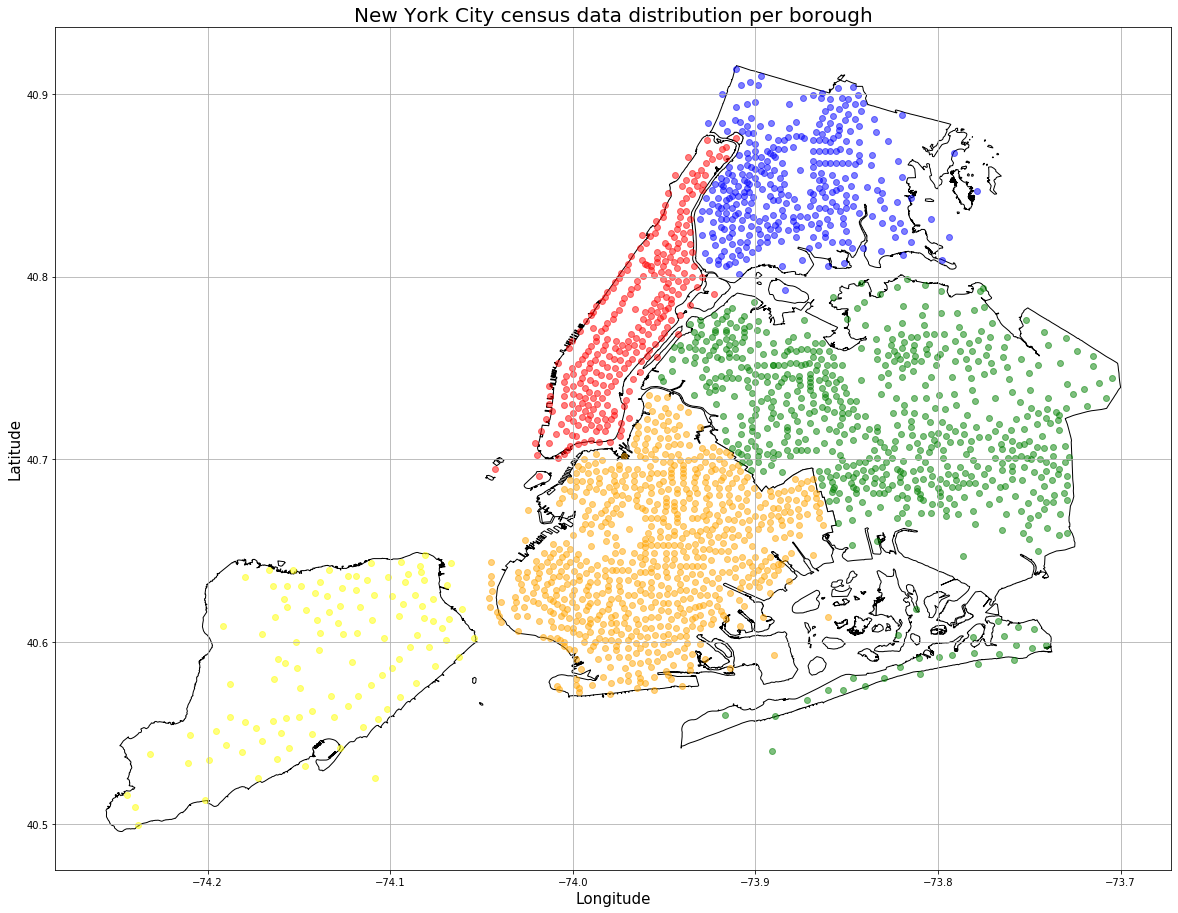

In [12]:
def census_evaluation(df):
    colors = ['Blue', 'Orange', 'Red', 'Green', 'Yellow']
    
    fig, ax = plt.subplots(figsize=(20, 20))
    world = geopandas.read_file(geopandas.datasets.get_path("nybb")) # open new york city map
    world.to_crs({"init": "epsg:4326"}).plot(ax=ax, color="white", edgecolor="black")
    boroughs = sorted(set(df['Borough']))

    for index, borough  in enumerate(boroughs):

        df_borough = df.loc[df['Borough'] == borough]
        x = df_borough['Longitude']
        y = df_borough['Latitude']

        geometry = [Point(xy) for xy in zip(x, y)]        
        geo_df = geopandas.GeoDataFrame(df_borough, geometry=geometry)

        plt.scatter(x, y, color=colors[index], alpha=0.5)
    
    plt.title("New York City census data distribution per borough", fontsize = 20)
    plt.grid(True)
    plt.xlabel("Longitude", fontsize = 15)
    plt.ylabel("Latitude", fontsize = 15)

census_evaluation(df)

### Calculating the mean distance between all points

Dentre de um borough, calcular a distância para todos pontos e ver aquele que o crime está mais perto, então adiciono os dados

In [20]:
df.to_csv("Output/census_data.csv", sep = ',', index = False)